In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import quandl
from fredapi import Fred
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import yfinance as yf
from pandas_datareader.data import DataReader
pd.set_option("display.max_rows",200)



In [3]:


pd.set_option("display.max_rows",200)
sns.set(rc={'figure.figsize':(16,10)})
fred_key = "df4910b2cad947d95cf6ab16ba11d74d"
fred = Fred(api_key = fred_key)
quandl.ApiConfig.api_key = 'Qq5R29Xiqp2yUbb9dzNq'

In [4]:
def plot(prediction,target,grey=None,start=None,end=None):
    # if start is None:
    #     start=df.index.min()
    # if end is None:
    #     end=df.index.max()
    # recessions=DataReader('USREC', 'fred', start=start,end=end)['USREC']

    # pd.concat([,target],axis=1,ignore_index=False).plot()
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # if isinstance(df,pd.DataFrame):
    # else:
    #     ylim = (df.min(),df.max())
        

    Results=pd.DataFrame(prediction,index=target.index)
    Results.plot(ax=ax,legend=True)
    Results['target']=target
    ylim = (Results.min().min(),Results.max().max())
    ax.fill_between(Results['target'].index, 0, ylim[1]+1e-2, Results['target'],facecolor='k', alpha=0.1)
    ax.legend(["Prediction", "NBER recession indicator"])
    return fig,ax

# DATA

In [5]:
df=pd.read_csv('Data\Transformed HistoricalVariables.csv',parse_dates=True,index_col=0)

## Adding Recession

In [15]:
recessions =  DataReader('USRECD', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-250)
df.shape

(2735, 126)

(<Figure size 3000x900 with 1 Axes>, <Axes: >)

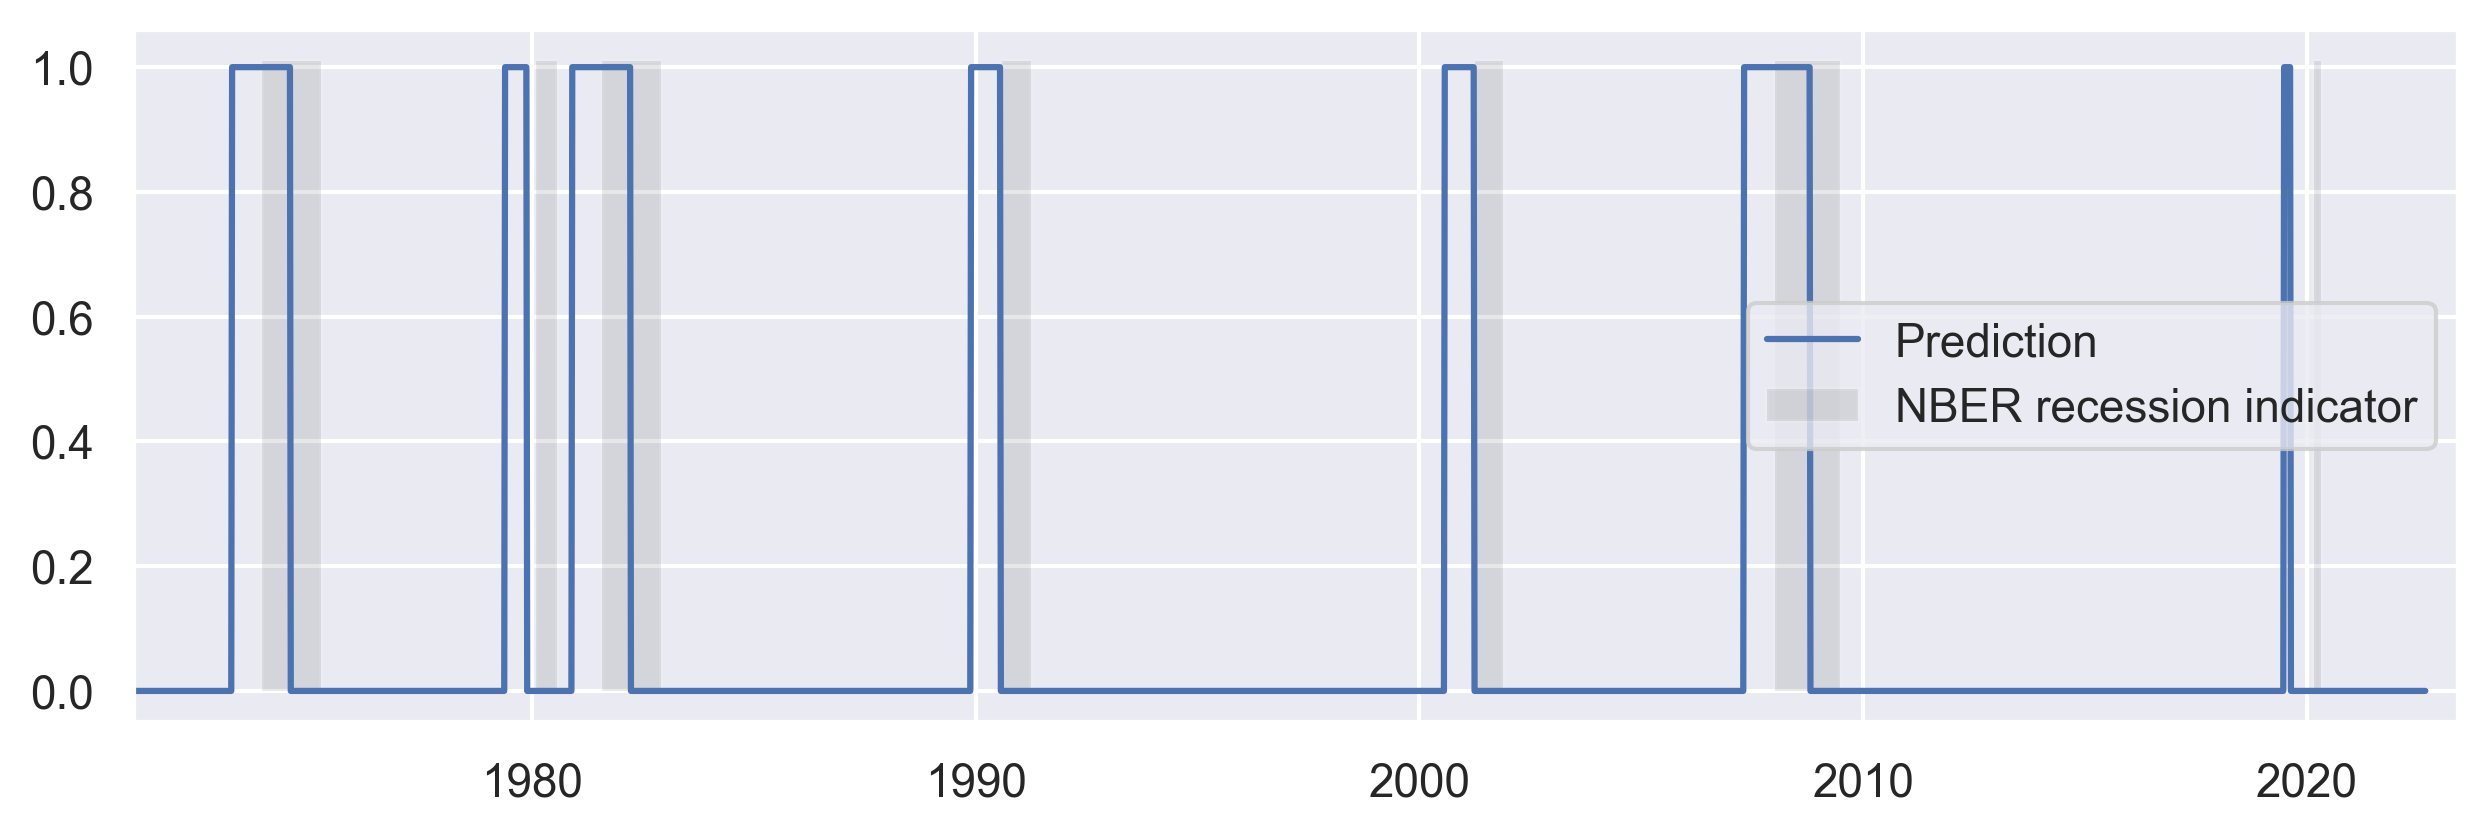

In [17]:
plot(df.iloc[:,-1],df.iloc[:,-2])

# Data Processing

In [18]:
def createXY(dataset,n_lookback = 60,n_forecast = 3,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:dataset.shape[1]-1])
        Y.append(dataset[i: i + n_forecast,target_col])

    return np.array(X),np.array(Y)

In [19]:
df.shape

(2735, 126)

In [39]:
n_lookback=30 
n_forecast=1

df_for_training=df[:"2003-01-01"]
df_for_validating=df["1996-01-01":"2003-01-01"]
df_for_testing=df["2003":]


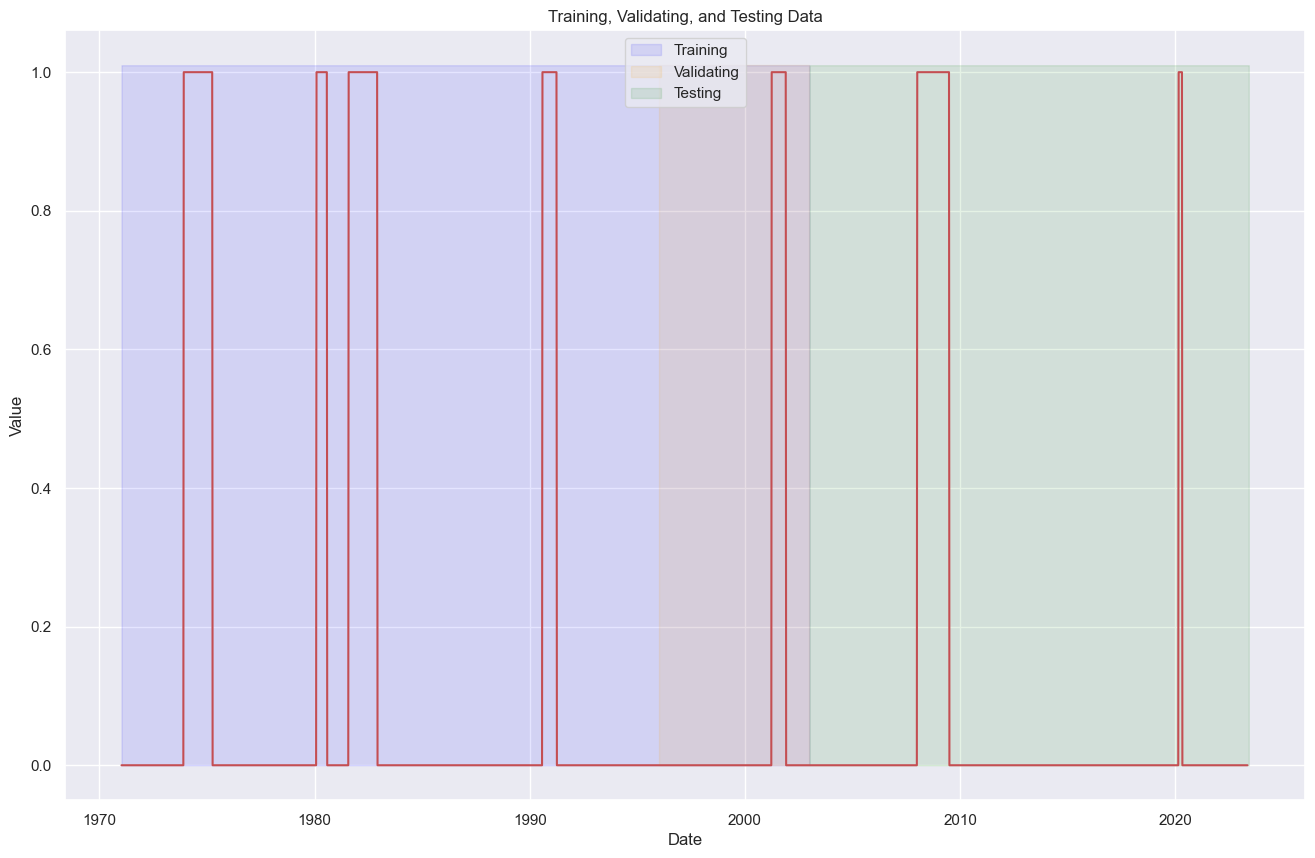

In [41]:
# Extract the last column from each dataframe
train_data = df_for_training.iloc[:, -2].copy()
valid_data = df_for_validating.iloc[:, -2].copy()
test_data = df_for_testing.iloc[:, -2].copy()

train_data.loc[:] =1
valid_data.loc[:] =1
test_data.loc[:]  =1

# Create a figure and axis
# Create a figure and axis
fig, ax = plt.subplots()

# Shade the training period
ax.fill_between(train_data.index, 0,1+1e-2, color='blue', alpha=0.1)
# Shade the validating period
ax.fill_between(valid_data.index,  0,1+1e-2, color='orange', alpha=0.1)
# Shade the testing period
ax.fill_between(test_data.index,  0,1+1e-2, color='green', alpha=0.1)

ax.plot(df.index, df.iloc[:,-2],color='r')


# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.set_title('Training, Validating, and Testing Data')

# Add legend
ax.legend(['Training','Validating','Testing'])

# Display the graph
plt.show()

In [42]:

print('df_for_training shape: ',df_for_training.shape)
print('df_for_validating shape: ',df_for_validating.shape)
print('df_for_testing shape: ',df_for_testing.shape)

# Scalling

scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
df_for_validating_scaled = scaler.transform(df_for_validating.fillna(0))
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))

print()
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
validX,validY=createXY(df_for_validating_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
trainX.shape,validX.shape,testX.shape

df_for_training shape:  (1669, 126)
df_for_validating shape:  (365, 126)
df_for_testing shape:  (1066, 126)



((1639, 30, 125), (335, 30, 125), (1036, 30, 125))

# Prediction 

In [19]:
data=data['Close']

In [41]:
# univariate multi-step cnn
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)//7))
	test = array(split(test, len(test)//7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 4
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(10, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores


In [51]:
data=data.resample('D').last().fillna(method='ffill')

In [53]:
data10

,DJI,NASDAQ,NYA,RUT,S&P
Date,,,,,
2010-10-19,-1.498413,-1.294634,-1.232938,-1.369108,-1.349627
2010-10-20,-1.434138,-1.265363,-1.150110,-1.321787,-1.304662
2010-10-21,-1.414957,-1.262098,-1.156842,-1.345507,-1.297004
2010-10-22,-1.414957,-1.262098,-1.156842,-1.345507,-1.297004
2010-10-23,-1.414957,-1.262098,-1.156842,-1.345507,-1.297004
...,...,...,...,...,...
2017-08-18,3.854316,4.125540,2.313937,2.583024,3.282832
2017-08-19,3.854316,4.125540,2.313937,2.583024,3.282832
2017-08-20,3.854316,4.125540,2.313937,2.583024,3.282832


In [52]:
train, test = split_dataset(data.values)
to_supervised(train, 30, n_out=1)

ValueError: array split does not result in an equal division

In [ ]:

# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('cnn', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='cnn')
pyplot.show()